# Predictive Modeling of Insurance Costs: A Machine Learning Approach

## Table of Contents

* [Introduction](#introduction)
* [Goal](#goal)
* [Summary](#summary)
* [The Data](#the_data)
* [Exploring the Dataset](#exploring_the_dataset)
* [Dividing the Data](#dividing_the_data)
* [Build The Model](#build_the_model)
* [Residual Diagnostics](#residual_diagnostics)
* [Interpreting The Model](#interpreting_the_model)
* [Final Model Evaluation](#final_model_evaluation)
* [Conclusion](#conclusion)
* [Next steps](#next_steps)

## Introduction  <a name="introduction"></a>

In this project, I explore the development of a predictive model for individual healthcare costs using a compact but informative dataset of medical costs. The dataset contains seven key features about our policyholders, such as age, BMI, smoking status and number of dependents.

While traditional pricing relies heavily on actuarial tables and broad demographic categories, we aim to investigate whether modern machine-learning approaches can offer improved accuracy in cost prediction. By systematically evaluating different modeling techniques on this dataset, we seek to identify the most effective approach for estimating insurance costs based on these readily available patient characteristics.

## Goal  <a name="goal"></a>

The primary goal of this project is to develop and validate a machine-learning model that accurately predicts individual healthcare insurance costs based on seven patient characteristics. We will evaluate multiple modeling approaches to identify the best-performing predictor, as measured by mean absolute error and R-squared metrics on our test set.

## Summary  <a name="summary"></a>
Our linear regression model predicts insurance charges using age, BMI, number of children and smoking status, achieving an $R^2$ of 0.77 on log-transformed data. Smoking is by far the strongest predictor, increasing charges by 366%, while each child adds 11% to the base cost. The model performs well for typical insurance costs but becomes less reliable for high-cost predictions, with an average prediction error of ±60%. The presence of non-linear patterns and distinct clusters in the residuals suggests that model performance could be improved by incorporating interaction terms or using more flexible modeling approaches.

## The Data <a name="the_data"></a>

For this project we'll be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. It has been uploaded to Kaggle by [Miri Choi](https://www.kaggle.com/mirichoi0218) under the [Database Contents License (DbCL)](https://opendatacommons.org/licenses/dbcl/1-0/).

This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it. You can download the dataset [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download).

The following is some boilerplate code that loads the required libraries, reads the data and displays some initial information about it:

In [53]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import seaborn as sns

In [54]:
# Reading the file
insurance = pd.read_csv("insurance.csv")

In [55]:
insurance.shape

(1338, 7)

In [56]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [57]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The dataset has 1338 observations, each with 7 predictors.
There are no missing predictors from any of the observations.

The predictors are as follows:

1. `Age`: age of primary beneficiary [years]
2. `Sex`: insurance contractor gender [`female', 'male']
3. `bmi`: Body mass index,  using the ratio of height to weigh [kg/m^2]9
4. `children`:Number of children covered by health insurance / Number of dependents 
5. `smoker`:Smoking ['yes', 'no'] 
6. `region`:The beneficiary's residential area in the US ['northeast', 'southeast', 'southwest', 'northwest'] 
7. `charges`:Individual medical costs billed by health insurance [$] 

## Exploring the Dataset <a name="exploring_the_dataset"></a>

The first step in developing our linear model is to explore the insurance dataset. We start by looking for correlations between predictors.
The dataset is composed of 7 columns - 4 numerical (`age`, `bmi`, `children`, `charges`) and 3 categorical (`sex`, `smoker` and `region`).
There are a couple of things we need to do before checking for correlations.
First, we'll convert the categorical variables into dummy ones.

In [58]:
insurance_dummies = pd.get_dummies(insurance)
insurance_dummies.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male',
       'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

Next, let's look at the distribution of `charges`:

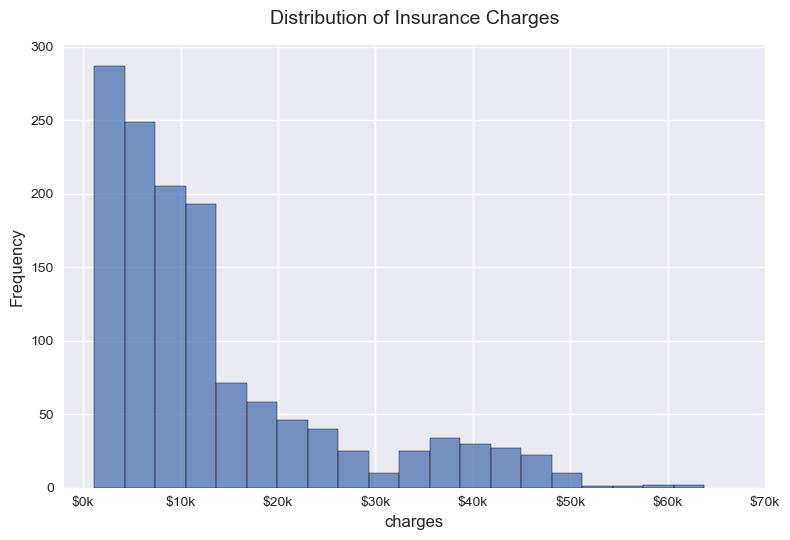

In [59]:
# Create histogram
sns.histplot(data=insurance['charges'], bins=20)

# Customize the plot
plt.title('Distribution of Insurance Charges', fontsize=14, pad=15)
plt.xlabel('charges', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Get the axis object
ax = plt.gca()

# Create fixed number of ticks
max_charge = insurance['charges'].max()
ticks = np.arange(0, max_charge + 10000, 10000)  # Add 10000 to include the last tick
ax.set_xticks(ticks)

# Format tick labels with 'k' for thousands
ax.set_xticklabels(['${:.0f}k'.format(x/1000) for x in ticks])

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

The histogram is heavily skewed to the right. This is due to the fact that there's a lower limit to the charges, but no upper one.
Looking at the log-transform will probably be beneficial in this case:

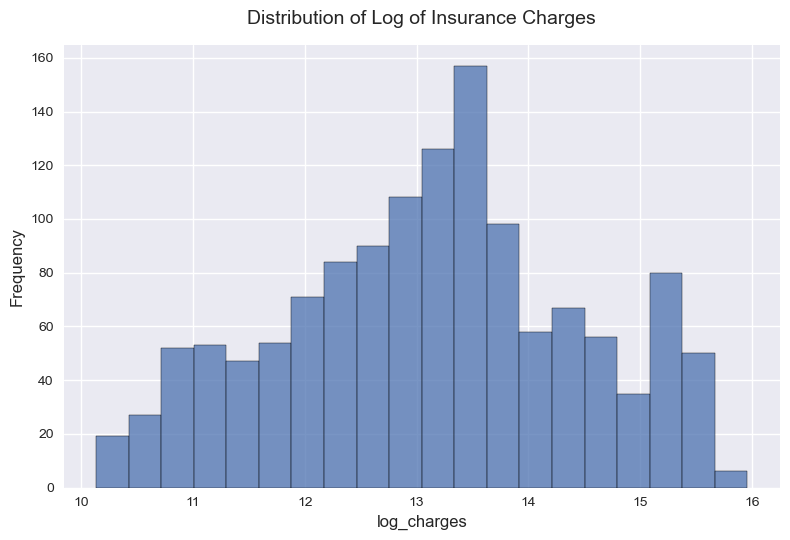

In [60]:
insurance["log_charges"] = np.log2(insurance["charges"])

# Create histogram
sns.histplot(data=insurance['log_charges'], bins=20)

# Customize the plot
plt.title('Distribution of Log of Insurance Charges', fontsize=14, pad=15)
plt.xlabel('log_charges', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

This is much better - it's more symmetric and closer to normal. This is important because it will be easier to model and make predictions with more normally distributed data.



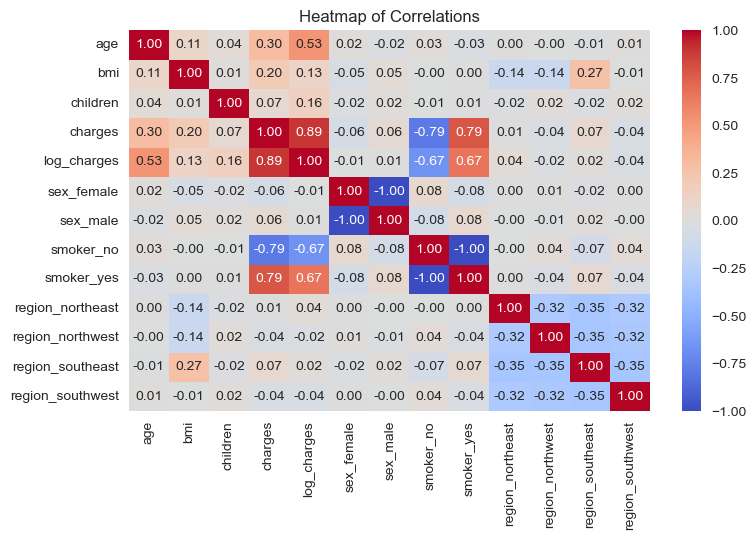

In [70]:
insurance_dummies = pd.get_dummies(insurance)
correlations = insurance_dummies.corr()

sns.heatmap(correlations, annot=True, fmt=".2f", cmap = 'coolwarm')
plt.title("Heatmap of Correlations")
plt.tight_layout()
plt.show()

As the heatmap clearly shows, two predictors are relatively highly-correlated with medical charges (being a smoker and `age`). `bmi` and `children` have a low correlation (`0.13` and `0.16` respectively) while the rest have a negligible correlation with medical costs (less than `0.05`).

We can also see that there are no significant correlations between any other pair of predictors in the dataset.

So moving forward, these are the predictors we'll use:
* `age`
* `bmi`
* `children`
* `smoker_yes`

The chosen predictors - age, BMI, number of children, and smoking status - are logical and relevant variables for predicting insurance costs. Age and health factors like BMI and smoking status are key determinants of healthcare utilization and associated costs, while the number of dependents can also impact a policyholder's insurance expenses.

These variables capture important demographic, healh, and family characteristics that are likely to drive differences in individual insurance charges, making them appropriate and meaningful predictors to include in the model.

## Dividing the Data <a name="dividing_the_data"></a>

Before we can build the model, we need to divide the `insurance` dataset into two portions:

1. A training set that will be used to estimate the regression coefficients
2. A test set that will be used to assess the predictive ability of the model

In [62]:
# Extract the predictor variables from the insurance dataset
X = insurance_dummies[['age', 'bmi', 'children', 'smoker_yes']]

# Extract the target variable from the dataset
y = insurance['log_charges']

# Split the data into training and testing sets, with 20% of the data reserved for testing
# Set a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=256)

## Build The Model <a name="build_the_model"></a>

Now that we've divided up the data into both a training and test set, we're ready to build our predictive linear model.

In [63]:
# Create and train a linear regression model, using our trainig set
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [64]:
# Get the model's predicted values
y_pred = model.predict(X_train)

print(f"r2 score: {r2_score(y_train, y_pred):.2f}")
print(f"Log of charge Mean Squared Error: {mean_squared_error(y_train, y_pred):.2f}")

r2 score: 0.77
Log of charge Mean Squared Error: 0.41


Some takeaways from these results:

* Our model's $R^2$ value is `0.77`, which indicates that about 77% of the variance in log-transformed insurance charges is explained by these four predictors
* An MSE of `0.41` on log-transformed data suggests reasonable prediction accuracy

These are preliminary results, and we can make our model better.

## Residual Diagnostics <a name="residual_diagnostics"></a>

 Before we examine or model more closely, we should check how well the assumptions of linear regression are met.
 We can do that by calculating the residuals and making sure that we have a zero mean and constant variance over the predicted values.

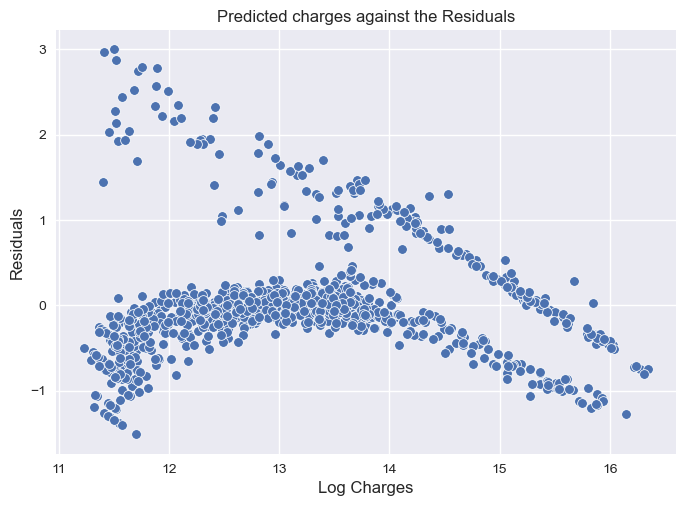

In [65]:
residuals = y_train - y_pred
sns.scatterplot(x=y_pred, y=residuals)

plt.xlabel('Log Charges', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title("Predicted charges against the Residuals")

plt.show()

This residual plot of predicted vs actual log charges reveals several important patterns that suggest our linear regression model might not be capturing all relationships in the data:
1. Non-Random Pattern:

    * There's a clear diagonal pattern/structure in the residuals
    * The points form distinct "bands" or clusters
    * This suggests our model is missing some important non-linear relationships or interactions between variables


2. Heteroscedasticity:

    * The spread of residuals isn't consistent across predicted values
    * The variation seems to be larger in the middle range of the predicted values
    * This violates one of the key assumptions of linear regression (constant variance)


3. Clustering:

    * There appear to be two distinct clusters in the data
    * This might be related to the smoking variable, which we saw had a very large coefficient
    * We might want to consider separate models for different groups or include interaction terms

These findings suggest we should consider:

* Adding interaction terms (especially with the smoking variable)
* Using a more flexible model that can capture non-linear relationships
* Transforming some of our predictor variables

## Interpreting The Model <a name="interpreting_the_model"></a>

Let's look at the intercept and coefficients of the model:

In [66]:
print(f"The coefficients: {model.coef_}")
print(f"The intercept: {model.intercept_}")

The coefficients: [0.05100151 0.01259923 0.14631215 2.2151957 ]
The intercept: 10.109738853429171


By itself, the intercept represents the predicted charges for a hypothetical person that's of age 0 (newborn) and has no kids, but also has a BMI of 0, which is impossible, and isn't a smoker nor a non-smoker (again, impossible in our dataset).
So it doesn't have a meaningful interpretation in this case.

As for the coefficients, we cna see that:
* Smoking has BY FAR the largest impact on insurance charges - being a smoker increases the log charges by about `2.22` units. That translates to an increase of about 366% ($2^2.22 - 1 = 3.66$) of the insurance charges
* Having children has the second-largest effect, but still only `0.15` log units, which is roughly an `11%` increase
* Age (`0.051`) and BMI (`0.013`) have smaller, but still positive effects (translated to `3.6%` and `0.9%` increase, respectively)

## Final Model Evaluation <a name="final_model_evaluation"></a>

Training error is almost always overly optimistic, so we shouldn't use it as the final judge of the model's predictive ability.

It's time to see how the model performs on the test data, which represents a set of new observations that it hasn't been trained on. Predictions should be accurate on any new observations if we want to use the model in the real world.

In [67]:
y_test_pred = model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test's MSE: {test_mse:.2f}")

Test's MSE: 0.46


Recall that the training data's MSE was 0.41. The test's MSE is slightly higher, but still fairly close. That tells us that the model performs reasonably well on unseen data and that we haven't overfit it

Since we're working in $log_2$ space, typical predictions are off by about $\sqrt{0.46} ≈ 0.68$ $log_2$ units. To understand this in dollar terms: when our model predicts an insurance charge, the actual charge is typically within a factor of $2^{0.68} ≈ 1.6$ (or ±60%) of the predicted value.

We can look at the scatter plot of the predicted log charges vs. the actual ones:

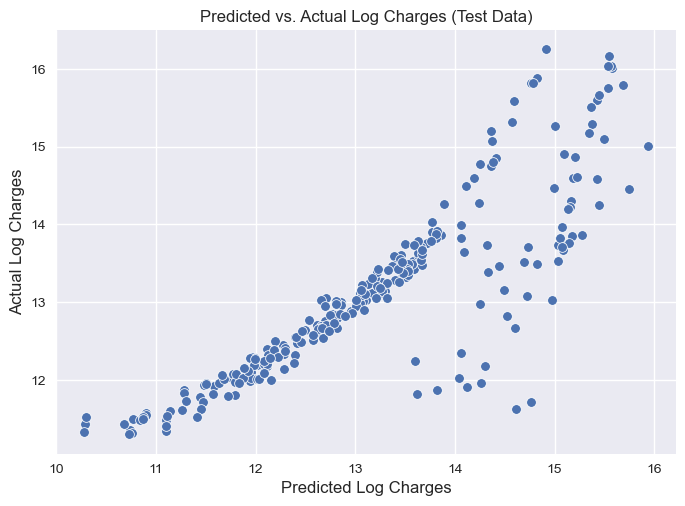

In [68]:
sns.scatterplot(x=y_test, y=y_test_pred)

plt.title("Predicted vs. Actual Log Charges (Test Data)")
plt.xlabel('Predicted Log Charges', fontsize=12)
plt.ylabel('Actual Log Charges', fontsize=12)
plt.show()

We can see that up to about $2^{13.5}$ (≈ 11,500\$), the model manages to predict the results quite well. But after that, the predictions start to become more erratic and don't match the actual data well enough.

## Conclusion <a name="conclusion"></a>

Here are the key conclusions about the model based on our analysis:

Strengths:
1. Overall Performance:
   - $R^2$ of 0.77 indicates good explanatory power
   - Similar MSE values between training (0.41) and test (0.46) data show good generalization
   - The predicted vs. actual plot shows a strong positive correlation

2. Interpretability:
   - Clear hierarchy of feature importance (smoking >> children > age > BMI)
   - Coefficients are interpretable in terms of percentage changes

Limitations:
1. Non-Linear Patterns:
   - The residuals plot showed clear diagonal patterns
   - The Predicted vs. Actual plot shows two distinct "bands" of predictions
   - This suggests important non-linear relationships aren't being captured

2. Prediction Quality:
   - Better predictions for lower-cost insurance (tighter clustering around the diagonal)
   - More scattered/less accurate for high-cost insurance (>13.5 log charges)
   - Typical predictions are off by about ±60% in real dollars

## Next steps <a name="next_steps"></a>

Some suggestions for future improvements of the model: 
1. Consider interaction terms, especially with the smoking variable (given the distinct bands)
2. Explore non-linear transformations of predictors
3. Consider using more flexible models that can capture non-linear relationships